In [1]:
import numpy as np
import re
import copy

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torch.nn.functional as F
import matplotlib.pyplot as plt
import matplotlib
import sys
sys.path.append("attacks/")
import mister_ed.utils.pytorch_utils as utils
from attacks.utils import load_image, torch_to_image, get_expl, convert_relu_to_softplus, plot_overview, UniGrad
from captum.attr import visualization as viz

In [2]:
data_mean = np.array([0.485, 0.456, 0.406])
data_std = np.array([0.229, 0.224, 0.225])
np.random.seed(72)
torch.manual_seed(72)
torch.cuda.manual_seed(72)
trasform_imagenet = torchvision.transforms.Compose([torchvision.transforms.Resize(256),
                                        torchvision.transforms.CenterCrop(224),
                                        torchvision.transforms.ToTensor()])

imagenet_val = torchvision.datasets.ImageNet(root="../Robust_Explanations/notebooks/data/", split="val", transform=trasform_imagenet)

test_loader = torch.utils.data.DataLoader(
        imagenet_val,
        batch_size=1024,
        shuffle=True
    )
BATCH_SIZE = 4
indices = np.random.randint(1024, size=BATCH_SIZE)
#### load images #####
dataiter = iter(test_loader)
images_batch, labels_batch = next(dataiter)
examples = images_batch[indices]
labels = labels_batch[indices]

In [3]:
normalizer = utils.DifferentiableNormalize(mean=[0.485, 0.456, 0.406],
                                               std=[0.229, 0.224, 0.225])

In [4]:
model = torchvision.models.vgg16(pretrained=True)

In [5]:
org_expl = get_expl(model, normalizer.forward(examples), "saliency", desired_index=labels,
                       smooth=False, normalize=True)
org_expl = org_expl.detach()
mask = torch.zeros_like(org_expl).view(BATCH_SIZE, -1)
topk_perbatch = torch.argsort(org_expl.view(BATCH_SIZE, -1))[:, -1000:]
for _ in range(mask.size()[0]):
    mask[_][topk_perbatch[_]] = 1
mask = mask.view(org_expl.size())

/home/ahmad/anaconda3/envs/pytorch_robust_expls/lib/python3.9/site-packages/captum/_utils/gradient.py:56: UserWarning: Input Tensor 0 did not already require gradients, required_grads has been set automatically.
  warnings.warn(


In [6]:
x_adv = torch.load("examples/output_expl_topk_relu_l1/x_saliency.pth")

In [7]:
x_adv = x_adv.cpu()

In [8]:
delta = x_adv[1] - examples[1]

In [9]:
x_adv[1].max()

tensor(1.0085)

In [20]:
np.where(np.abs(delta.numpy()) > 0.00)[1].shape

(150506,)

In [13]:
a = np.where(delta.numpy() > 0.009)
b = np.where(delta.numpy() < -0.009)

In [14]:
ex = copy.deepcopy(examples[1]).unsqueeze(dim=0)

In [15]:
ex[0, a[0], a[1], a[2]] = 1.0
ex[0, b[0], b[1], b[2]] = 0.0

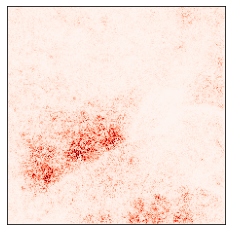

(<Figure size 288x288 with 1 Axes>, <AxesSubplot:>)

In [16]:
orig_expl = get_expl(model, normalizer.forward(examples[1].unsqueeze(dim=0)), method="saliency", desired_index=labels[1])
ex_expl = get_expl(model, normalizer.forward(ex), method="saliency", desired_index=labels[1])
viz.visualize_image_attr(np.transpose(ex_expl.squeeze().cpu().detach().numpy(), (1,2,0)),
                             np.transpose(examples[1].cpu().detach().numpy(), (1,2,0)),
                             method='heat_map',
                             cmap="Reds",
                             show_colorbar=False,
                             outlier_perc=2,
                             fig_size=(4,4))

In [17]:
_, topk_mask_ind = torch.topk(mask[1].flatten(), k=1000)
_, topk_adv_ind = torch.topk(ex_expl[0].flatten(), k=1000)
topk_ints = float(len(np.intersect1d(topk_mask_ind.cpu().detach().numpy(),
                    topk_adv_ind.cpu().detach().numpy())))/1000

In [18]:
topk_ints

0.099

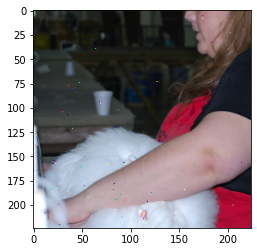

In [19]:
plt.imshow(ex.squeeze().permute(1,2,0).numpy())

In [103]:
image_array = np.random.randint(0, 256, (3, 24, 24)).astype(np.uint8)/255

In [106]:
inds = []
for i in range(3):
    for j in range(224):
        for k in range(224):
            inds.append([i,j,k])

In [117]:
to_pick = np.random.choice(range(len(inds)), size=100, replace=False)

In [119]:
pixels = np.array(inds)[to_pick]

In [125]:
ex[0][pixels[:,0], pixels[:,1], pixels[:,2]]

tensor([0.0824, 0.8627, 0.1608, 0.9961, 0.5765, 0.1098, 0.7294, 0.0549, 0.2745,
        0.0471, 0.6471, 0.5608, 0.4941, 0.0627, 0.6824, 0.0667, 0.7137, 0.7451,
        0.0627, 0.6824, 0.6588, 0.7490, 0.5412, 0.2471, 0.8353, 0.6667, 0.1961,
        0.1804, 0.2078, 0.0745, 0.1725, 0.0745, 0.1961, 0.4706, 0.5882, 0.1490,
        0.1804, 0.4431, 0.1216, 0.2235, 0.2941, 0.0353, 0.7176, 0.1216, 0.2118,
        0.0392, 0.5569, 0.6588, 0.8353, 0.1608, 0.6314, 0.0078, 0.1098, 0.1843,
        0.7647, 0.0353, 0.5725, 0.1098, 0.5294, 0.3098, 0.7020, 0.2078, 0.1608,
        0.1059, 0.2392, 0.1059, 0.5882, 0.2353, 0.6196, 0.2392, 0.0431, 0.0706,
        0.5216, 0.6275, 0.0902, 0.1569, 0.1137, 0.7804, 0.7098, 0.3529, 0.0706,
        0.1804, 0.6863, 0.8784, 0.0941, 0.3216, 0.1451, 0.8784, 0.0588, 0.5725,
        0.7059, 0.8824, 0.8078, 0.3020, 0.2157, 0.0980, 0.6118, 0.5333, 0.2471,
        0.7373])

In [137]:
x = np.array([1, 0, 1, 0])

In [141]:
x[[]]=1
x

array([1, 0, 1, 0])

In [136]:
np.array([1,1,1,1]) == np.array([1,1,1,1])

array([ True,  True,  True,  True])

In [147]:
3*224*224

150528

In [89]:
ex[0][[0,1,1,2,2], [12, 13, 144, 15, 15], [2,2,2,2,2]]

tensor([0.0980, 0.1059, 0.8627, 0.0941, 0.0941])

In [91]:
np.where(ex[0][[0,1,1,2,2], [12, 13, 144, 15, 15], [2,2,2,2,2]] < 0.5)[0]

array([0, 1, 3, 4])

In [92]:
x_adv_cifar = torch.load("examples/output_expl_topk_relu_random_pert_cifar/x_saliency.pth")

In [95]:
x_adv_cifar.size()

torch.Size([4, 3, 32, 32])

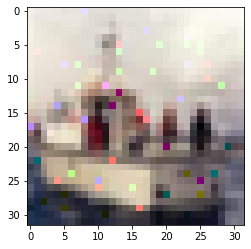

In [98]:
plt.imshow(x_adv_cifar[0].permute(1,2,0).cpu().numpy())

In [103]:
sys.path.append("../pytorch-cifar/models/")
from resnet import ResNet18, ResNet50
model_rn18 = ResNet18()
model_rn18.load_state_dict(torch.load("../Robust_Explanations/notebooks/models/RN18_standard.pth")["net"])
model_rn18 = model_rn18.eval().cuda()


In [104]:
normalizer_cifar = utils.DifferentiableNormalize(mean=[0.4914, 0.4822, 0.4465],
                                               std=[0.2023, 0.1994, 0.2010])

/home/ahmad/anaconda3/envs/pytorch_robust_expls/lib/python3.9/site-packages/captum/_utils/gradient.py:56: UserWarning: Input Tensor 0 did not already require gradients, required_grads has been set automatically.
  warnings.warn(


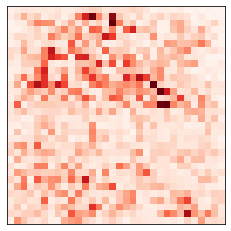

(<Figure size 288x288 with 1 Axes>, <AxesSubplot:>)

In [105]:
adv_expl_cifar = get_expl(model_rn18, normalizer_cifar.forward(x_adv_cifar[0:1]), method="saliency", desired_index=8)
viz.visualize_image_attr(np.transpose(adv_expl_cifar.squeeze().cpu().detach().numpy(), (1,2,0)),
                             np.transpose(x_adv_cifar[0].cpu().detach().numpy(), (1,2,0)),
                             method='heat_map',
                             cmap="Reds",
                             show_colorbar=False,
                             outlier_perc=2,
                             fig_size=(4,4))

In [108]:
np.random.randint(512, size=1)

array([325])

In [113]:
x_adv_cifar[[2]].size()

torch.Size([1, 3, 32, 32])

In [115]:
torch.norm(x_adv_cifar, p=1, dim=(1,2,3))

tensor([1916.2078, 1308.7177, 1295.6785, 1592.8353], device='cuda:0')

In [116]:
torch.sum(x_adv_cifar[0])

tensor(1916.2079, device='cuda:0')

In [117]:
d = nn.Parameter(torch.zeros((2,2)))

In [119]:
d.parameters()

AttributeError: 'Parameter' object has no attribute 'parameters'

In [27]:
a=np.array([1,0,0,1,0])
sum(a[np.where(a==2)[0]])

0

### results of the random perturbation attack against cifar-10

In [28]:
with open("examples/output_expl_topk_relu_random_pert_cifar/output.log", "r") as f:
    lines = f.readlines()

In [68]:
lines[1:3]

['batch [5] finished\n', '13\n']

In [84]:
batches = []
num_pixels = []
all_topk_ints = []
for i,l in enumerate(lines):
    if l.strip().endswith("finished"):
        nums = l.strip().split(" ")[1:-1]
#         nums = itertools.chain(*nums)
        nums = [a.strip().strip("[").strip(']').strip(',') for a in nums]
        nums = [int(a) for a in nums if a!='']
        batches = batches + nums
        num_pixels = num_pixels + [int(lines[i+1].strip())]*len(nums)
    if l.strip().startswith("Final topk intersection:"):
        topk_ints = l.strip().split(" ")[3:]
        topk_ints = [a.strip().strip("[").strip(']').strip(',') for a in topk_ints]
        topk_ints = [float(a) for a in topk_ints if a!='']
        all_topk_ints = all_topk_ints + topk_ints

In [87]:
np.mean(all_topk_ints)

0.0015625

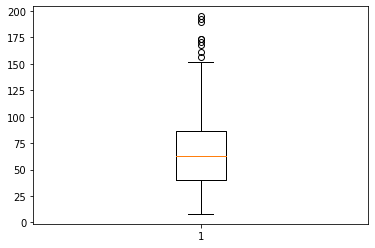

In [80]:
plt.boxplot(num_pixels);